# **Model Selection and Validation**
Laboratory 1 of the Machine Learning class by Prof. F. Chiariotti at University of Padova during academic year 2024-2025.

In [14]:
# importing all the necessary python libraries
import numpy as np
import random
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

# **Polynomial Classification on Signal to Noise Ratios**

In this notebook we are going to explore **polynomial classification** with **polynomial regression**. We are going to use the Numpy ``polyfit`` function, which performs polynomial regression.

The dataset consists of three features:
- the coordinates of the positions (in meters) and relative to the transmitter which is in (0,0)
- the Signal to Noise Ratio (SNR), i.e. the quality of the communication link in various positions, which depends on two components: the noise level, which is a random variable that does not depend on position, and the signal attenuation, which is usually modeled as a polynomial function of the distance. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. We will try with a maximum of 6.

In [15]:
# loading the data and unpacking it into separate variables
df = pd.read_csv('data/snr_measurements.csv',sep=';') 
x = df['x'].to_numpy() 
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy() 

In [16]:
# defining helper functions that we will need to evaluate the results

def compute_distance(x, y):
    # function that computes the Euclidean distance using the Pythagorean theorem
    distance = np.sqrt(x**2+y**2)
    return distance

def fit(distance, SNR, degree):
    # function that fits the SNR measurements with a polyfit of given degree, and returns the 
    # fitted polynomial curve evaluated at the input distances
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    # function that predicts the SNR from a given model parameters
    deg = len(poly_coeffs)
    pred = poly_coeffs[-1]
    for n in range(1, deg):
        pred += poly_coeffs[deg - n - 1] * (distance ** n)
    return pred
    
def evaluate(distance, SNR, poly_coeffs):
    # function that evaluates the quality of the fit (of given coefficients) by computing
    # its mean squared error on the test set
    mse = 0
    for i in range(len(distance)):
        mse += (predict(distance[i], poly_coeffs) - SNR[i]) ** 2
    mse /= len(distance)
    return mse
    
def separate_test(distance, SNR, n_test):
    # function that splits the training and test sets randomly based on 
    # an input number of test points
    idx = list(range(len(distance))) # used to be x
    test_idx = random.sample(idx, n_test)
    train_idx = [i for i in idx if i not in test_idx]
    x_train = distance[train_idx]
    x_test = distance[test_idx]
    y_train = SNR[train_idx]
    y_test = SNR[test_idx]
    return x_train, y_train, x_test, y_test

## 1. **Performing k-fold cross validation**

In [17]:
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int):
    # function that performs k-fold cross validation on the training data (x_train, y_train)
    # for an input k and a given maximum degree max_degree

    # initializing variables
    best = -1
    best_perf = 1e20
    results = []
    
    # splitting the training set in K folds
    x_folds = []
    y_folds = []
    fold_points = int(np.floor(len(x_train) / k))
    idx = list(range(len(x_train)))
    for i in range(k):
        fold_idx = random.sample(idx, fold_points)
        idx = [i for i in idx if i not in fold_idx]
        x_folds.append(x_train[fold_idx])
        y_folds.append(y_train[fold_idx])

    for deg in range(max_degree + 1):
        degree_perf = 0
        # training and validating are performed for each degree value
        for test in range(k):
            # training on all folds but one
            x_train_fold = [x for i, x in enumerate(x_folds) if i != test] 
            y_train_fold = [x for i, x in enumerate(y_folds) if i != test]
            x_train_fold = np.concatenate(x_train_fold)
            y_train_fold = np.concatenate(y_train_fold)
            # validating on the remaining fold
            x_validate_fold = x_folds[test]
            y_validate_fold = y_folds[test]
            k_model = fit(x_train_fold, y_train_fold, deg)
            degree_perf += evaluate(x_validate_fold, y_validate_fold, k_model)
        degree_perf /= k
        results.append(degree_perf)
        # if the results obtained for the current degree are better than the ones found before,
        # we overwrite best and best_perf
        if (best_perf > degree_perf):
            best = fit(x_train, y_train, deg)
            best_perf = degree_perf
    # the overall best degree and all the results are returned
    return tuple([tuple(best), tuple(results)])

the best model found with k-fold cross validation corresponds to degree :  3
the parameters of the best model are:  (-5.032613235587295e-06, 0.0002477584517473209, -0.014011892366149019, 10.118686327577707)
the (minimum) MSE of the best model is:  1.0067830191235874


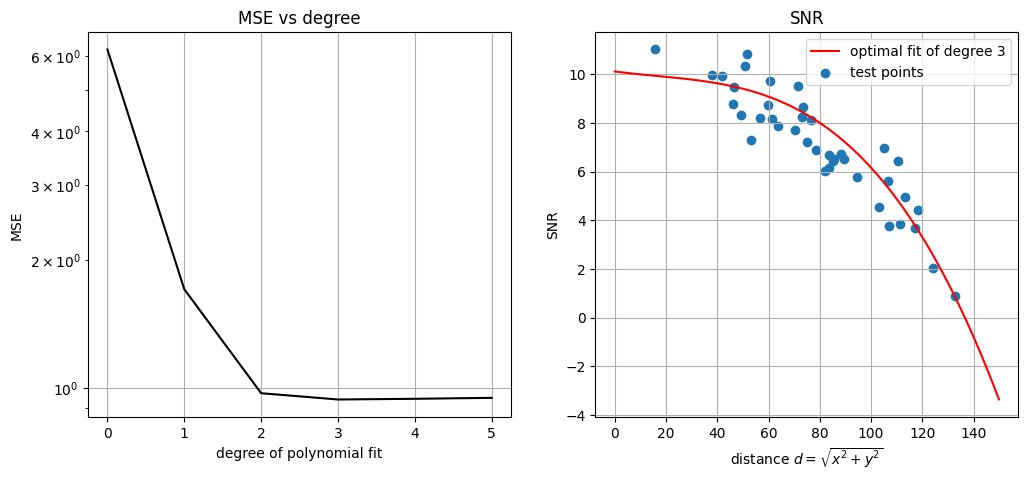

In [18]:
# initializing the parameters of k-fold cross validation
K = 4
max_degree = 5
test_points = 40
# running the training with K-fold cross-validation
distance = compute_distance(x, y)
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)
best_model, results = k_fold_cross_validation(x_train, y_train, K, max_degree)
dist_vals = np.arange(0,150,0.1)
pred_SNR_kfold = [predict(dist_vals[i], best_model) for i in range(len(dist_vals))]
print('the best model found with k-fold cross validation corresponds to degree : ', len(best_model)-1)
print('the parameters of the best model are: ', best_model)
print('the (minimum) MSE of the best model is: ', evaluate(x_test, y_test, best_model))

# and displaying the results
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(range(max_degree + 1), results, 'k')
ax[0].set_xlabel('degree of polynomial fit')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('MSE vs degree')
ax[0].grid()
ax[1].plot(dist_vals, pred_SNR_kfold, 'r',label='optimal fit of degree '+str(len(best_model)-1))
ax[1].scatter(x_test, y_test, label='test points')
ax[1].set_xlabel('distance $d = \sqrt{x^2 + y^2}$')
ax[1].set_ylabel('SNR')
ax[1].set_title('SNR')
ax[1].grid()
ax[1].legend()

plt.show()

## 2. **Tikhonov regularization**

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [19]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int):
    # function that computes the optimal degree (between 0 and max_degree) of a polynomial fit 
    # of (x_train, y_train) by adding a Tikhonov regularization term to the loss function
    # the evaluation of the quality of the fit is based on the empirical risk

    # initializing
    results = []
    best = -1
    best_perf = 1e9

    for deg in range(max_degree + 1):
        # training and evaluating the performance for each degree
        k_model = np.polyfit(x_train, y_train, deg)
        loss = evaluate(x_train, y_train, k_model) 
        loss += np.sum(k_model ** 2) * lambda_par
        results.append(loss)
        # if the results obtained for the current degree are better than the ones found
        # before, we overwrite best and best_perf
        if (best_perf > loss):
            best_perf = loss
            best = k_model
    # the overall best degree and all the results are returned
    return tuple([tuple(best), tuple(results)])

the best model found with k-fold cross validation corresponds to degree :  4
the parameters of the best model are:  (-1.242584229523049e-07, 3.312959320564367e-05, -0.0037752199275122985, 0.1537526655366082, 7.880666968162968)
the (minimum) loss of the best model is:  0.9854003719994587


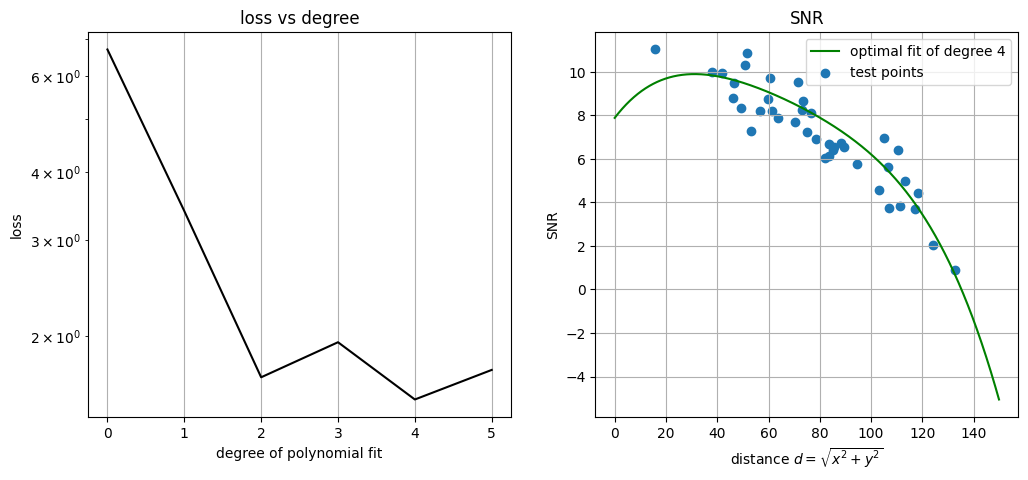

In [20]:
# Run the training with Tikhonov regularization and plot the loss as a function of the degree
max_degree = 5
test_points = 40
lambda_par = 0.01

distance = compute_distance(x, y)
best_model_tkh, results = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)
dist_vals = np.arange(0,150,0.1)
pred_SNR_tkn = [predict(dist_vals[i], best_model_tkh) for i in range(len(dist_vals))]
print('the best model found with k-fold cross validation corresponds to degree : ', len(best_model_tkh)-1)
print('the parameters of the best model are: ', best_model_tkh)
print('the (minimum) loss of the best model is: ', evaluate(x_test, y_test, best_model_tkh))

# and displaying the results
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(range(max_degree + 1), results, 'k')
ax[0].set_xlabel('degree of polynomial fit')
ax[0].set_ylabel('loss')
ax[0].set_yscale('log')
ax[0].set_title('loss vs degree')
ax[0].grid()
ax[1].plot(dist_vals, pred_SNR_tkn, 'g',label='optimal fit of degree '+str(len(best_model_tkh)-1))
ax[1].scatter(x_test, y_test, label='test points')
ax[1].set_xlabel('distance $d = \sqrt{x^2 + y^2}$')
ax[1].set_ylabel('SNR')
ax[1].set_title('SNR')
ax[1].grid()
ax[1].legend()

plt.show()

## 3. **Minimum description length regularization**

The minimum description length of a polynomial of degree $N$ is $O(2^N)$, so try $\lambda=0.02$.

In [21]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: int, max_degree: int):
    # function that computes the optimal degree (between 0 and max_degree) of a polynomial fit 
    # of (x_train, y_train) by including, in the loss function, a representation length regularization
    # the evaluation (of parameter lambda_par) in the loss

    results = []
    best = -1
    best_perf = 1e9
    for deg in range(max_degree + 1):
        # training and evaluating for each degree
        k_model = np.polyfit(x_train, y_train, deg)
        loss = evaluate(x_train, y_train, k_model) 
        loss += np.power(2, deg + 1) * lambda_par
        results.append(loss)
        # if the results obtained for the current degree are better than the ones found
        # before, we overwrite best and best_perf
        if (best_perf > loss):
            best_perf = loss
            best = k_model
    return tuple([tuple(best), tuple(results)])

the best model found with k-fold cross validation corresponds to degree :  2
the parameters of the best model are:  (-0.0009193274549035408, 0.06666805660916768, 8.553831114563431)
the (minimum) loss of the best model is:  1.0715995756634822


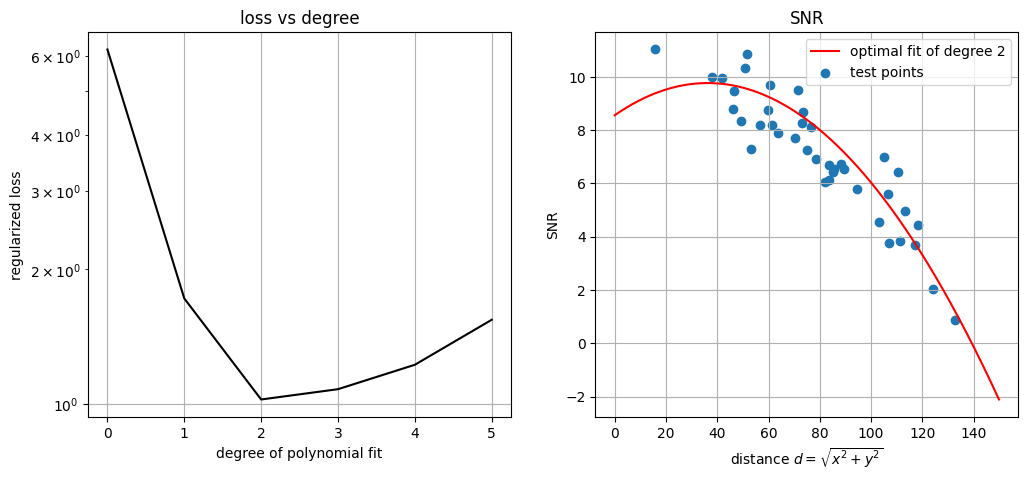

In [22]:
# Run the training with MDL regularization and plot the loss as a function of the degree
max_degree = 5
test_points = 40
lambda_par = 0.01

distance = compute_distance(x, y)
best_model_mdl, results = evaluate_representation(x_train, y_train, lambda_par, max_degree)
dist_vals = np.arange(0,150,0.1)
pred_SNR_mdl = [predict(dist_vals[i], best_model_mdl) for i in range(len(dist_vals))]
print('the best model found with k-fold cross validation corresponds to degree : ', len(best_model_mdl)-1)
print('the parameters of the best model are: ', best_model_mdl)
print('the (minimum) loss of the best model is: ', evaluate(x_test, y_test, best_model_mdl))

# and displaying the results
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(range(max_degree + 1), results, 'k')
ax[0].set_xlabel('degree of polynomial fit')
ax[0].set_ylabel('regularized loss')
ax[0].set_yscale('log')
ax[0].set_title('loss vs degree')
ax[0].grid()
ax[1].plot(dist_vals, pred_SNR_mdl, 'r',label='optimal fit of degree '+str(len(best_model_mdl)-1))
ax[1].scatter(x_test, y_test, label='test points')
ax[1].set_xlabel('distance $d = \sqrt{x^2 + y^2}$')
ax[1].set_ylabel('SNR')
ax[1].set_title('SNR')
ax[1].grid()
ax[1].legend()

plt.show()

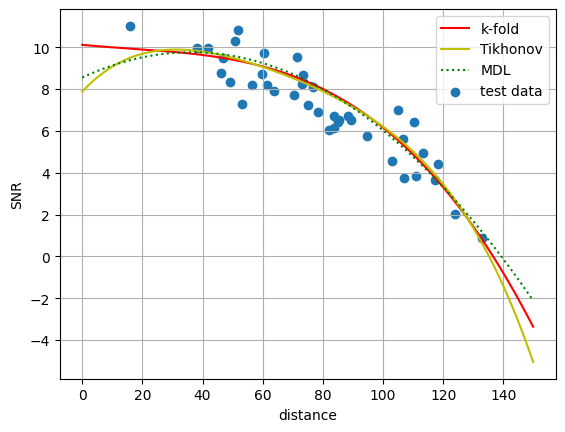

In [23]:
# comparing the results obtained with different methods

plt.plot(dist_vals, pred_SNR_kfold, 'r', label='k-fold')
plt.plot(dist_vals, pred_SNR_tkn, 'y', label='Tikhonov')
plt.plot(dist_vals, pred_SNR_mdl, ':g', label='MDL')
plt.scatter(x_test, y_test, label='test data')
plt.xlabel('distance')
plt.ylabel('SNR')
plt.legend()
plt.grid()
plt.show()